# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
###
#!pip install openslide-python
#https://github.com/deroneriksson/python-wsi-preprocessing/
###
sys.path.append('../python-wsi-preprocessing/')
from deephistopath.wsi import slide, filter, tiles, util

import sys
sys.path.append('../fastai/') #fastai version 1.0
from fastai.vision import *
from fastai.core import parallel

import pandas as pd
import numpy as np
import os
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

PATH = Path('/home/Deep_Learner/work/network/datasets/Hypophysenadenome/')
FONT_PATH=PATH/'1984-Happines-Regular.ttf'
ROIS_CORTICOTROP = PATH/'rois_corticotrop'
ROIS_CORTICOTROP_FILTERED = PATH/'rois_corticotrop_filtered'
ROIS_GONADOTROP = PATH/'rois_gonadotrop'
ROIS_GONADOTROP_FILTERED = PATH/'rois_gonadotrop_filtered'
TILES_CORTICOTROP = PATH/'tiles_corticotrop'
TILES_GONADOTROP = PATH/'tiles_gonadotrop'
slide.BASE_DIR = PATH
#slide.TRAIN_PREFIX = 'hypophysen'
#slide.SRC_TRAIN_DIR = ROIS_CORTICOTROP
slide.SRC_TRAIN_DIR = ROIS_GONADOTROP

def show(np):
    return util.np_to_pil(np)

Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

def show_multiple_images(path, rows = 3, figsize=(128, 64)):
    imgs = [open_image(p) for p in path.ls()]
    show_all(imgs=imgs, r=rows, figsize=figsize)
    
def show_multiple_images_big(path:pathlib.Path):
    for p in path.ls():
        plt.imshow(mpimg.imread(str(p)))
        plt.show()
        
class AdenomaType(Enum):
    corticotrop = 1
    gonadotrop = 2

In [2]:
adenomaType = AdenomaType.corticotrop

if adenomaType == AdenomaType.gonadotrop:
    rois_filtered_path = ROIS_GONADOTROP_FILTERED
    rois_path = ROIS_GONADOTROP
    tiles_path = TILES_GONADOTROP
    
if adenomaType == AdenomaType.corticotrop:
    rois_filtered_path = ROIS_CORTICOTROP_FILTERED
    rois_path = ROIS_CORTICOTROP
    tiles_path = TILES_CORTICOTROP

# Overwrite parts of wsi lib

In [3]:
slide.SCALE_FACTOR = 1
slide.BASE_DIR = PATH/'data'
tiles.SUMMARY_TITLE_FONT_PATH = str(FONT_PATH)
tiles.FONT_PATH = str(FONT_PATH)
tiles.DISPLAY_TILE_SUMMARY_LABELS = True
tiles.LABEL_ALL_TILES_IN_TOP_TILE_SUMMARY = True
tiles.BORDER_ALL_TILES_IN_TOP_TILE_SUMMARY = True
tiles.TISSUE_LOW_THRESH = 20

##################################################################################################################

slide.open_slide = slide.open_image

##################################################################################################################

def get_image_path(folder_path, slide_num):
    return folder_path.ls()[slide_num]

slide.get_filter_image_result = partial(get_image_path, rois_filtered_path)
slide.get_training_image_path = partial(get_image_path, rois_path)
slide.get_training_slide_path = partial(get_image_path, rois_path)

##################################################################################################################

def parse_dimensions_from_image_filename(img_path):
    shape = slide.open_image_np(img_path).shape
    return shape[1], shape[0], shape[1], shape[0]

slide.parse_dimensions_from_image_filename = parse_dimensions_from_image_filename

##################################################################################################################

def tile_to_pil_tile(tile):
  """
  Convert tile information into the corresponding tile as a PIL image read from the whole-slide image file.

  Args:
    tile: Tile object.

  Return:
    Tile as a PIL image.
  """
  t = tile
  filepath = slide.get_training_image_path(t.slide_num)
  img = slide.open_image_np(filepath)
  x, y = t.o_c_s, t.o_r_s
  w, h = t.o_c_e - t.o_c_s, t.o_r_e - t.o_r_s
  tile = img[t.o_r_s:t.o_r_e, t.o_c_s:t.o_c_e,:]
  tile_pil = util.np_to_pil(tile)
  return tile_pil

tiles.tile_to_pil_tile = tile_to_pil_tile

##################################################################################################################
def get_tile_image_path(tile):
  """
  Obtain tile image path based on tile information such as row, column, row pixel position, column pixel position,
  pixel width, and pixel height.

  Args:
    tile: Tile object.

  Returns:
    Path to image tile.
  """
  t = tile
  roi_name = slide.get_training_image_path(t.slide_num).stem
  tile_path = os.path.join(PATH, tiles_path,
                           roi_name + "-" + 'tile' + "-r%d-c%d-x%d-y%d-w%d-h%d" % (
                             t.r, t.c, t.o_c_s, t.o_r_s, t.o_c_e - t.o_c_s, t.o_r_e - t.o_r_s) + "." + 'png')
  return tile_path

slide.get_tile_image_path = get_tile_image_path

##################################################################################################################

def top_tiles(self):
    """
    Retrieve the top-scoring tiles.

    Returns:
       List of the top-scoring tiles.
    """
    sorted_tiles = self.tiles_by_score()
    top_tiles = [tile for tile in sorted_tiles
                 if check_tile(tile)]
    print(f'Number of top tiles/all tiles: {len(top_tiles)}/{len(sorted_tiles)}')
    return top_tiles

def check_tile(tile):
    width = tile.o_c_e - tile.o_c_s
    height = tile.o_r_e - tile.o_r_s
    return tile.score > 0.55 and width >= 0.7*tiles.COL_TILE_SIZE and height >= 0.7*tiles.ROW_TILE_SIZE


tiles.TileSummary.top_tiles = top_tiles

##################################################################################################################
from deephistopath.wsi.tiles import (hsv_saturation_and_value_factor, 
                                     hsv_purple_pink_factor, 
                                     tissue_quantity_factor, 
                                     tissue_quantity)

def score_tile(np_tile, tissue_percent, slide_num, row, col):
  """
  Score tile based on tissue percentage, color factor, saturation/value factor, and tissue quantity factor.

  Args:
    np_tile: Tile as NumPy array.
    tissue_percent: The percentage of the tile judged to be tissue.
    slide_num: Slide number.
    row: Tile row.
    col: Tile column.

  Returns tuple consisting of score, color factor, saturation/value factor, and tissue quantity factor.
  """
  color_factor = hsv_purple_pink_factor(np_tile)
  s_and_v_factor = hsv_saturation_and_value_factor(np_tile)
  amount = tissue_quantity(tissue_percent)
  quantity_factor = tissue_quantity_factor(amount)
  combined_factor = color_factor * s_and_v_factor
  score = tissue_percent * combined_factor / 1000.0
  # scale score to between 0 and 1
  score = 1.0 - (10.0 / (10.0 + score))
  print(f'tp: {tissue_percent}')
  print(f'cf: {combined_factor}')
  print(f'score: {score}')  
  return score, color_factor, s_and_v_factor, quantity_factor

tiles.score_tile = score_tile
#tiles.score_tile = tiles.score_tile
#############################################################################################################

# Filter images

In [5]:
def filter_roi(img_path:pathlib.Path, index:int):
    if img_path.suffix == '.png':
        try:
            img_pil = slide.open_image(img_path)
            img_np = util.pil_to_np_rgb(img_pil)
            grayscale_np = filter.filter_rgb_to_grayscale(img_np)
            complement_np = filter.filter_complement(grayscale_np)
            otsu_np = filter.filter_otsu_threshold(complement_np).astype(np.bool)
            filtered_img_np = util.mask_rgb(img_np, otsu_np)
            filtered_img_pil = util.np_to_pil(filtered_img_np)
            filtered_path = rois_filtered_path/f'{img_path.stem}-filtered{img_path.suffix}'
            filtered_img_pil.save(filtered_path)
        except:
            print(img_path)
            
failed = []
try:
    parallel(filter_roi, rois_path.ls(), max_workers=25)
except:
    failed.append(img_path)
    
print(failed)

RGB                  | Time: 0:00:00.124005  Type: uint8   Shape: (1706, 2448, 3)
RGB                  | Time: 0:00:00.172908  Type: uint8   Shape: (1944, 2997, 3)
RGB                  | Time: 0:00:00.266974  Type: uint8   Shape: (3369, 2848, 3)
RGB                  | Time: 0:00:00.275412  Type: uint8   Shape: (3089, 3089, 3)
Gray                 | Time: 0:00:00.221026  Type: uint8   Shape: (1706, 2448)
Complement           | Time: 0:00:00.002901  Type: uint8   Shape: (1706, 2448)
Otsu Threshold       | Time: 0:00:00.046010  Type: uint8   Shape: (1706, 2448)
Mask RGB             | Time: 0:00:00.011410  Type: uint8   Shape: (1706, 2448, 3)
Gray                 | Time: 0:00:00.264409  Type: uint8   Shape: (1944, 2997)
Complement           | Time: 0:00:00.006957  Type: uint8   Shape: (1944, 2997)
RGB                  | Time: 0:00:00.488548  Type: uint8   Shape: (4374, 4009, 3)
Otsu Threshold       | Time: 0:00:00.079179  Type: uint8   Shape: (1944, 2997)
Mask RGB             | Time: 0:00:

Otsu Threshold       | Time: 0:00:01.323706  Type: uint8   Shape: (9256, 9767)
Gray                 | Time: 0:00:05.646914  Type: uint8   Shape: (8237, 15014)
RGB                  | Time: 0:00:03.677928  Type: uint8   Shape: (13222, 9691, 3)
Complement           | Time: 0:00:00.091371  Type: uint8   Shape: (8237, 15014)
Mask RGB             | Time: 0:00:00.241348  Type: uint8   Shape: (6122, 5831, 3)
Otsu Threshold       | Time: 0:00:01.321763  Type: uint8   Shape: (9839, 9766)
Mask RGB             | Time: 0:00:00.529374  Type: uint8   Shape: (9256, 9767, 3)
Otsu Threshold       | Time: 0:00:01.494194  Type: uint8   Shape: (13410, 7434)
Otsu Threshold       | Time: 0:00:01.448884  Type: uint8   Shape: (12828, 7434)
Mask RGB             | Time: 0:00:00.576893  Type: uint8   Shape: (9839, 9766, 3)
RGB                  | Time: 0:00:01.154606  Type: uint8   Shape: (5622, 7861, 3)
Gray                 | Time: 0:00:07.324406  Type: uint8   Shape: (15221, 8024)
Complement           | Time: 0:

RGB                  | Time: 0:00:05.069865  Type: uint8   Shape: (6925, 23394, 3)
Otsu Threshold       | Time: 0:00:01.491162  Type: uint8   Shape: (10714, 14139)
Mask RGB             | Time: 0:00:00.824271  Type: uint8   Shape: (10714, 14139, 3)
Gray                 | Time: 0:00:09.478912  Type: uint8   Shape: (16366, 12275)
Complement           | Time: 0:00:00.108875  Type: uint8   Shape: (16366, 12275)
Otsu Threshold       | Time: 0:00:02.309581  Type: uint8   Shape: (16366, 12275)
Gray                 | Time: 0:00:09.384822  Type: uint8   Shape: (14285, 11588)
Gray                 | Time: 0:00:05.746032  Type: uint8   Shape: (6925, 23394)
Complement           | Time: 0:00:00.093116  Type: uint8   Shape: (14285, 11588)
Complement           | Time: 0:00:00.077241  Type: uint8   Shape: (6925, 23394)
Gray                 | Time: 0:00:10.976308  Type: uint8   Shape: (19625, 11512)
Complement           | Time: 0:00:00.113615  Type: uint8   Shape: (19625, 11512)
Mask RGB             | Ti

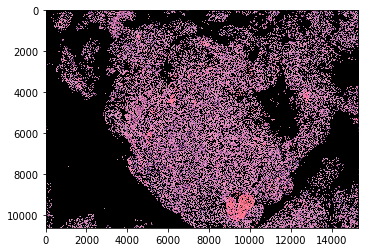

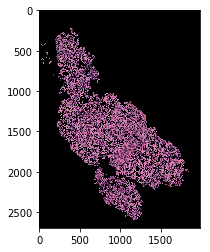

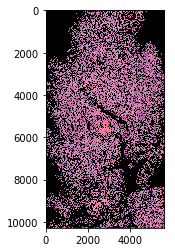

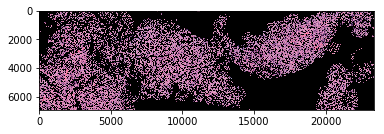

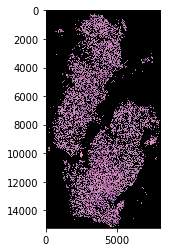

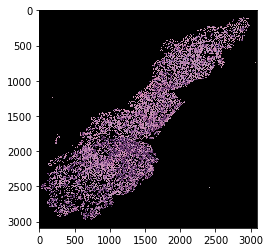

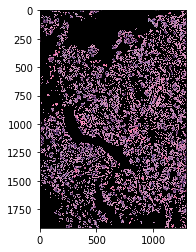

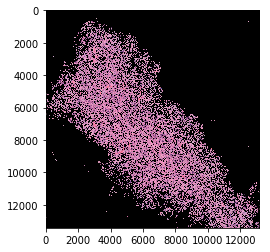

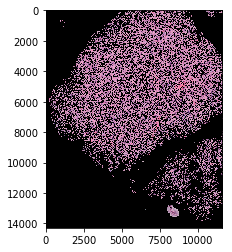

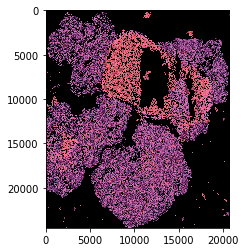

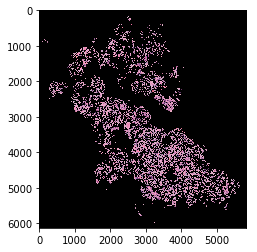

KeyboardInterrupt: 

In [6]:
show_multiple_images_big(rois_filtered_path)

# Create tiles

## multi process

In [7]:
tiles.multiprocess_filtered_images_to_tiles(display=False, 
                                            save_summary=False, 
                                            save_data=False, 
                                            save_top_tiles=True,
                                            html=True, 
                                            image_num_list=list(range(0, len(rois_filtered_path.ls()))))

Generating tile summaries (multiprocess)

RGB                  | Time: 0:00:00.166015  Type: uint8   Shape: (2695, 1991, 3)
Number of processes: 32
Number of training images: 46
Task #1: Process slides [0]
Task #2: Process slides [1]
Task #3: Process slides [2, 3]
Task #4: Process slides [4]
Task #5: Process slides [5, 6]
Task #6: Process slides [7]
Task #7: Process slides [8, 9]
Task #8: Process slides [10]
Task #9: Process slides [11]
Task #10: Process slides [12, 13]
Task #11: Process slides [14]
Task #12: Process slides [15, 16]
Task #13: Process slides [17]
Task #14: Process slides [18, 19]
Task #15: Process slides [20]
Task #16: Process slides [21, 22]
Task #17: Process slides [23]
Task #18: Process slides [24]
Task #19: Process slides [25, 26]
Task #20: Process slides [27]
Task #21: Process slides [28, 29]
Task #22: Process slides [30]
Task #23: Process slides [31, 32]
Task #24: Process slides [33]
Task #25: Process slides [34]
Task #26: Process slides [35, 36]
Task #27: Process

tp: 57.52859115600586
cf: 210.26200132376093
score: 0.5474309701520164
tp: 3.279876708984375
cf: 287.17043268162695
score: 0.08608057322831053
tp: 2.9043197631835938
cf: 42.81888117919914
score: 0.01228321851954095
tp: 47.74675369262695
cf: 195.08877833335373
score: 0.4822638036198854
tp: 47.70917892456055
cf: 180.5200644701917
score: 0.4627256245976554
RGB                  | Time: 0:00:04.688412  Type: uint8   Shape: (13222, 9691, 3)
RGB                  | Time: 0:00:09.151218  Type: uint8   Shape: (19625, 11512, 3)
tp: 45.277451157742405
cf: 473.18767648623555
score: 0.6817793059153383
RGB                  | Time: 0:00:09.295776  Type: uint8   Shape: (6414, 6633, 3)
tp: 22.348585912486655
cf: 1290.7834560465342
score: 0.7425810902433532
RGB                  | Time: 0:00:04.929101  Type: uint8   Shape: (15221, 8024, 3)
tp: 0.14542079207920722
cf: 27.670239227126963
score: 0.0004022209637410956
RGB                  | Time: 0:00:01.477751  Type: uint8   Shape: (5404, 5604, 3)
RGB       

tp: 19.63491439819336
cf: 253.93945813289005
score: 0.3327140707607593
RGB                  | Time: 0:00:06.553437  Type: uint8   Shape: (12828, 7434, 3)
tp: 0.0
cf: 0.0
score: 0.0
tp: 18.959426879882812
cf: 487.25188611879554
score: 0.48019589252430817
tp: 43.45121383666992
cf: 747.4627262058608
score: 0.7645849219387121
tp: 0.0012106146694179643
cf: 15.02068153676493
tp: 2.9013633728027344
cf: 333.90285340188547
score: 1.8184224347406186e-06
score: 0.08832104228840565
tp: 65.39077758789062
cf: 137.24973554631012
score: 0.47298708147423363
RGB                  | Time: 0:00:06.066280  Type: uint8   Shape: (13410, 7434, 3)
tp: 1.6076087951660156
cf: 95.8939652984786
score: 0.015181953237903723
tp: 0.13837814331054688
cf: 3.838585962343993
score: 5.311481850700517e-05
tp: 14.902019500732422
tp: 64.06898498535156
tp: 25.170326232910156
cf: 338.53492870629975
cf: 149.39083528030707
cf: 224.51444587298735
score: 0.3353209059139466
score: 0.36106734861245904
score: 0.48904823907170036
tp: 9.

cf: 126.53871712253328
score: 0.20095650479622762
tp: 27.196502685546875
cf: 808.3170722540985
score: 0.6873377813275401
tp: 2.906513214111328
cf: 192.4756736980487
score: 0.05297946246576635
tp: 48.75926971435547
cf: 214.5116715261217
score: 0.5112278884071856
tp: 27.33770461309524
tp: 63.043975830078125
cf: 339.197590301895
cf: 170.10249745077098
score: 0.48113628223422145
score: 0.5174662206352225
tp: 17.313098907470703
cf: 401.46416292332265
tp: 0.2665519714355469
cf: 1.6298507799141657
score: 0.4100499905168403
score: 4.344210655460312e-05
tp: 0.0
cf: 0.0
score: 0.0
tp: 47.20888137817383
cf: 166.21691234227134
score: 0.439679054817815
tp: 0.0
cf: 0.0
score: 0.0
tp: 0.0003814697265625
cf: 0.0
score: 0.0
tp: 2.8029441833496094
cf: 255.2722112158768
score: 0.06677363079837573
tp: 9.5367431640625e-05
cf: 12.800000000000002
score: 1.2207029753685816e-07
tp: 5.589866638183594
cf: 1631.402656259612
score: 0.47696893594621537
tp: 16.17746353149414
cf: 318.43081044257667
score: 0.339995106

tp: 25.987625122070312
tp: 11.20452880859375
cf: 1613.3587568544235
tp: 0.006198883056640625
cf: 259.4977419968928
score: 0.8074233023419783
cf: 17.444772859993183
score: 0.22525963042137054
score: 1.0813693753553011e-05
tp: 5.165767669677734
cf: 246.32171409984701
score: 0.11288067736094365
tp: 34.024620056152344
cf: 248.98644154618282
score: 0.458630405264432
tp: 28.703784942626953
cf: 192.39004069280972
score: 0.3557665037170882
tp: 0.006103515625
cf: 94.21161263760789
tp: 66.31650924682617
cf: 115.00337174416823
score: 5.749889866557556e-05
tp: 0.01392364501953125
cf: 6.792942725010977
score: 0.43267632868049855
score: 9.458162856468277e-06
tp: 0.0
cf: 0.0
score: 0.0
tp: 0.11138916015625
cf: 20.43093027727311
score: 0.0002275266363279682
tp: 16.55120849609375
cf: 282.2397835213236
score: 0.31840222999796297
tp: 0.0
cf: 0.0
tp: 0.6724357604980469
score: 0.0
cf: 87.45931873781907
score: 0.005846692499971939
tp: 56.41298294067383
cf: 273.855677429438
score: 0.6070574935400171
tp: 14.2

tp: 0.4525184631347656
tp: 25.528717041015625
cf: 5.543435628333268
score: 0.0002507877868108688
cf: 348.76755789184926
score: 0.4709999053042344
tp: 0.003426535087726279
cf: 29.541474955045032
score: 1.0122387583799686e-05
tp: 71.42477035522461
cf: 166.72384490759833
score: 0.5435501606900549
tp: 0.0
cf: 0.0
tp: 26.710796356201172
score: 0.0
cf: 291.5224979339726
tp: 2.9662132263183594
score: 0.4377852631195335
cf: 306.24046825389956
score: 0.08327313341594311
tp: 43.90602111816406
cf: 205.99595879868338
score: 0.4749129947407974
tp: 57.238006591796875
cf: 152.35367645525437
score: 0.4658239715674528
tp: 22.548198699951172
cf: 198.86473619376363
score: 0.30958497042775546
tp: 1.1403083801269531
cf: 59.566490434816686
score: 0.006746591162455906
tp: 18.895530700683594
cf: 286.6250843581508
score: 0.35132048463054366
tp: 70.01028060913086
cf: 136.1836284746861
score: 0.4880787370976303
tp: 0.020122528076171875
cf: 50.38196468225991
score: 0.00010137097276918805
tp: 1.6619682312011719
cf

tp: 69.7422981262207
cf: 1240.4318019309096
tp: 69.48308944702148
score: 0.8963844005251824
cf: 163.69471595541364
score: 0.5321421739678794
tp: 39.73665237426758
cf: 339.338609103787
score: 0.5741814339615914
tp: 2.287709736776449
tp: 68.47591400146484
cf: 144.73087086353934
cf: 84.85170551435215
score: 0.49775442655664426
score: 0.019041972006140884
tp: 35.546875
cf: 420.62443282741185
score: 0.5992286616260882
tp: 69.30322647094727
cf: 129.12976597469225
score: 0.47227071305903345
tp: 28.296470642089844
cf: 305.9758842872276
score: 0.46403795511852985
tp: 79.4001579284668
cf: 78.31477780107863
tp: 2.3949623107910156
score: 0.3834089806708251
cf: 46.921278499475086
score: 0.011112591946549344
tp: 5.2734375
cf: 426.8630781216713
score: 0.18374248569520346
tp: 54.35638427734375
cf: 157.9376298989193
score: 0.46192930581964764
tp: 47.85013198852539
cf: 183.91172275234047
score: 0.468090770874958
tp: 46.91486358642578
cf: 287.9811602935217
score: 0.5746598836459769
tp: 2.8882980346679688

cf: 112.59833049973474
score: 0.07182571142284766
tp: 31.37960433959961
cf: 206.9476371581102
score: 0.3937165378457286
tp: 36.10468433062881
cf: 262.5606184074615
score: 0.486644234691455
tp: 77.65331268310547
cf: 177.66483304291367
score: 0.5797659460164664
tp: 0.00019073486328125
cf: 0.0
score: 0.0
tp: 0.03561148966164751
tp: 29.02687590187591
cf: 50.888011775755196
cf: 289.1352615143648
score: 0.00018118695586322175
score: 0.45630583802606406
tp: 0.0
cf: 0.0
score: 0.0
tp: 68.53981018066406
cf: 1341.99267557068
score: 0.9019414833669286
tp: 39.46533203125
cf: 169.8276007237437
score: 0.4012801582408787
tp: 70.83520889282227
cf: 198.4406658979946
score: 0.5843134187463972
tp: 5.12726151315789
cf: 283.3455039978223
score: 0.12685004630812358
tp: 77.55002975463867
cf: 185.24633458498366
score: 0.5895896755001512
tp: 31.521892547607422
cf: 288.1245077180772
score: 0.4759522278498274
tp: 59.92412567138672
cf: 161.21103934204552
score: 0.4913641408449617
tp: 66.67938232421875
cf: 198.559

cf: 186.71773633455038
score: 0.01438451188744716
tp: 39.975929260253906
cf: 320.86942628489277
score: 0.5619233114900304
tp: 49.474334716796875
cf: 186.97740799131034
score: 0.4805352093045888
tp: 13.856029510498047
cf: 385.0637165799078
score: 0.3479162823408275
tp: 6.545022269275705
cf: 1372.5807541376462
score: 0.4732287364283039
tp: 26.46646499633789
tp: 35.8062744140625
cf: 241.4079333493173
cf: 148.17939309924296
score: 0.34665085437965193
score: 0.389842635343726
tp: 37.45880126953125
cf: 225.211426301663
score: 0.4575874048181203
tp: 14.288520812988281
cf: 295.09429931535556
score: 0.2965900603829067
tp: 36.866092681884766
tp: 80.23862838745117
cf: 82.22650049873434
cf: 314.8045870072053
score: 0.39750839417296147
score: 0.5371573564383388
tp: 57.48739242553711
cf: 115.12902469023595
score: 0.39825979459455696
tp: 10.247915069018404
cf: 192.85612636381796
score: 0.1650226800661172
tp: 72.3318099975586
cf: 121.11308057068769
score: 0.4669602885941063
tp: 62.305259704589844
cf: 

score: 0.6148702284388317
tp: 77.34441757202148
cf: 136.72672594407786
score: 0.5139744256527029
tp: 61.10801696777344
cf: 184.41423473823494
score: 0.5298363100277913
tp: 16.04117321210269
cf: 234.47950462889247
score: 0.2733258592378677
tp: 77.5996208190918
cf: 89.53975703561869
tp: 24.74079132080078
cf: 282.9296150159828
score: 0.40996862240137266
tp: 75.64115524291992
tp: 55.8873176574707
cf: 81.19319613187827
score: 0.41176133436077744
cf: 236.0783891595663
score: 0.38048069958598596
score: 0.5688500717751104
tp: 63.88444900512695
cf: 125.81409809752415
score: 0.4456014229632014
tp: 36.8316650390625
cf: 283.1130935060703
score: 0.5104644736479846
tp: 9.892461404382473
cf: 386.1110832681686
score: 0.2763894781578069
tp: 12.916374206542969
cf: 171.52400108037588
score: 0.18136580195722452
tp: 4.253494231744426
cf: 113.30908231697653
score: 0.04597990735894941
tp: 5.489253997802734
cf: 287.9769325638061
score: 0.13650019508454858
tp: 11.79351806640625
cf: 283.73648530604373
score: 0.

score: 0.34200237672781686
tp: 19.84405517578125
cf: 348.9815029129537
score: 0.4091653182432927
tp: 0.0
cf: 0.0
score: 0.0
tp: 65.17753601074219
cf: 134.6068216343848
score: 0.4673297619757285
tp: 77.3092269897461
cf: 973.9137748901433
score: 0.882756426096477
tp: 71.3296890258789
cf: 171.08374242438876
score: 0.5496175156040473
RGB                  | Time: 0:00:00.172432  Type: uint8   Shape: (3346, 1018, 3)
tp: 0.276947021484375
cf: 8.483778763362583
score: 0.00023490053471897365
tp: 62.911033630371094
cf: 190.50145417188608
score: 0.5451370384961773
tp: 60.639381408691406
cf: 125.5211499135897
score: 0.4321899968571491
tp: 20.80249786376953
cf: 296.68727373985814
score: 0.38164103530678983
tp: 55.322933197021484
cf: 159.7098284288276
score: 0.4690909015008522
tp: 26.06954574584961
cf: 319.6891574245875
score: 0.4545697841226558
tp: 48.14281463623047
tp: 11.728050595238102
cf: 159.20841983949958
cf: 155.24212587958027
score: 0.15734155574022313
score: 0.4277144027643469
tp: 0.0
cf: 

score: 0.36398604365330933
tp: 48.19374084472656
tp: 78.55291366577148
cf: 220.7610451809164
cf: 337.40535690741126
score: 0.5154874579436619
score: 0.7260587231696605
tp: 49.94821548461914
cf: 197.8650850394095
score: 0.497057988003339
tp: 6.479644775390625
cf: 147.7705253036504
score: 0.08738311361892359
tp: 0.0
cf: 0.0
score: 0.0
tp: 52.33383752349624
tp: 48.83270263671875
cf: 226.82926439760564
cf: 221.39359026217693
score: 0.5427703134986652
score: 0.5194905991206629
tp: 0.013256072998046875
cf: 14.40231381779111
score: 1.909144784051353e-05
tp: 17.586421966552734
cf: 506.5973981458147
score: 0.47115789311921363
tp: 53.14531326293945
tp: 64.22586441040039
cf: 179.20889415297844
cf: 218.67693370652862
score: 0.5375006956988899
score: 0.5350966280137482
tp: 33.792781829833984
cf: 275.81845140717877
score: 0.482419679282455
tp: 77.4662971496582
cf: 147.24445453615056
score: 0.5328517928541078
tp: 35.95104217529297
cf: 201.781912581972
score: 0.42043332048571813
tp: 89.02044296264648


tp: 77.01282501220703
cf: 333.1474174699651
score: 0.7195471992542202
tp: 0.0
cf: 0.0
score: 0.0
tp: 2.0879745483398438
cf: 153.76244794787706
score: 0.031106526290666348
tp: 58.13798904418945
cf: 111.4766688037294
score: 0.3932417819372205
tp: 0.9823799133300781
cf: 13.115386693567148
score: 0.0012867713305186879
tp: 82.56311416625977
cf: 60.28676129943782
score: 0.33233017080450356
tp: 27.93865203857422
cf: 296.1731081560997
score: 0.45279471836490737
tp: 0.000286102294921875
cf: 416.13491638490405
score: 1.1905573713000273e-05
tp: 15.27872085571289
cf: 503.93579501210604
score: 0.4350121078472181
tp: 70.8643913269043
cf: 194.08110887335695
score: 0.5790083395063179
tp: 6.341743469238281
cf: 731.6766353166105
tp: 0.002384185791015625
score: 0.31694481410186726
cf: 57.18874185784745
score: 1.3634672667461878e-05
tp: 10.27948288690476
cf: 251.9635199165943
score: 0.20572227481556715
tp: 68.09368133544922
cf: 972.6370237848001
score: 0.8688188001616264
tp: 65.61546325683594
cf: 97.21549

cf: 97.91888671854662
tp: 0.008106231689453125
cf: 45.245309604307856
score: 0.4337308652570918
score: 3.6675551105869175e-05
tp: 35.02025604248047
cf: 392.32548586038075
score: 0.5787582790752369
tp: 2.18866974818512
cf: 39.29193579062283
score: 0.008526382727000903
tp: 81.73503875732422
cf: 76.18918812167924
score: 0.38375553374429017
tp: 19.876956939697266
tp: 67.86346435546875
cf: 280.3488987365723
cf: 154.13541541250862
score: 0.357841648789912
score: 0.5112453469626563
tp: 76.24263763427734
cf: 262.4384307090041
score: 0.6667666163973316
tp: 83.26950073242188
cf: 412.8274261268922
score: 0.7746526286947789
tp: 68.70126724243164
cf: 103.75483534711921
score: 0.41616369507689976
tp: 40.65208435058594
cf: 288.19271177846383
score: 0.5395022865690525
tp: 61.092281341552734
cf: 130.36575013369617
score: 0.44334167599140506
tp: 0.0003814697265625
cf: 6.880830485233527
score: 2.6248278339746633e-07
tp: 20.610713958740234
cf: 122.37328816411144
score: 0.2014183346092111
tp: 38.1640434265

tp: 0.8489583333333286
cf: 47.38153230370833
score: 0.00400637903123624
tp: 28.61013412475586
cf: 212.51464743545563
score: 0.3781122592214653
tp: 60.44120788574219
cf: 155.59247871907093
score: 0.48464758326553536
tp: 35.340118408203125
cf: 203.4077073545109
score: 0.4182140584501568
tp: 56.20029472305389
tp: 32.13050343165888
cf: 158.9140351214554
cf: 852.1102675008309
score: 0.47176632219323356
score: 0.7324681844829387
tp: 0.0
cf: 0.0
score: 0.0
tp: 71.6618537902832
cf: 110.7715924958796
score: 0.4425272854210577
RGB                  | Time: 0:00:01.263706  Type: uint8   Shape: (5404, 5604, 3)
tp: 5.996744791666671
cf: 185.25664709362985
score: 0.0999858832985887
tp: 59.842681884765625
cf: 139.0617657385916
score: 0.45420296222314693
tp: 87.30535507202148
cf: 557.4220669633842
score: 0.8295433184555938
tp: 3.528118133544922
cf: 336.3264750186334
score: 0.10607330060932474
tp: 0.8402824401855469
cf: 146.4844090091997
score: 0.012159162627800701
tp: 0.0046866280691943984
cf: 127.9755

cf: 201.5601735782847
score: 0.11793584587233563
tp: 31.814098358154297
cf: 391.8290506932499
score: 0.5548767516692545
tp: 82.916259765625
cf: 136.45245431492654
score: 0.5308276088091985
tp: 36.550331115722656
cf: 308.8015834918845
score: 0.5302253067180118
tp: 61.85951232910156
cf: 126.91327004847003
score: 0.4398007974346587
tp: 41.025638580322266
cf: 918.0896246667412
score: 0.7902033927010437
tp: 75.16613006591797
cf: 345.0594366545775
score: 0.7217335747545275
RGB                  | Time: 0:00:01.037597  Type: uint8   Shape: (5404, 5604, 3)
tp: 8.956034613059245
cf: 369.05551892089164
score: 0.2484183340530649
tp: 22.878170013427734
cf: 288.8628405148307
score: 0.3979042193177579
tp: 0.09088516235351562
cf: 27.229762471322378
score: 0.00024741690802954075
tp: 81.46810531616211
cf: 367.35226862638643
score: 0.7495460102462851
RGB                  | Time: 0:00:02.294211  Type: uint8   Shape: (7435, 8601, 3)
tp: 0.029659271240234375
cf: 64.43385831969664
score: 0.000191069613521888

score: 0.5686841247599033
tp: 1.0561943054199219
cf: 167.77675929447008
score: 0.017411937779134745
tp: 43.39303970336914
cf: 153.47482777613286
score: 0.3997505109274594
tp: 29.34131622314453
cf: 255.79938764786172
score: 0.4287506612394487
tp: 0.01321663533835249
cf: 21.767768842600635
score: 2.87688386224616e-05
tp: 20.20263671875
cf: 242.1691089652343
score: 0.32851901760791247
tp: 61.49301528930664
cf: 143.75407549018115
score: 0.4692108188168058
tp: 0.04863739013671875
cf: 1.1403094158582292
score: 5.5461366338382945e-06
tp: 24.877011865601503
cf: 267.43548028044825
score: 0.39950743815363277
tp: 23.201560974121094
cf: 155.9463840479691
score: 0.2656885389318878
tp: 78.24134826660156
cf: 203.66572455416463
score: 0.6144218695744994
tp: 0.001430511474609375
cf: 35.49281051990842
score: 5.0772614927918625e-06
tp: 29.905223846435547
cf: 1342.0042994370997
score: 0.8005303458375138
tp: 15.33365249633789
cf: 137.97463240186897
score: 0.17462159948738787
tp: 40.12298583984375
cf: 229.2

tp: 22.837543487548828
cf: 217.41679340101206
score: 0.3317859935577351
tp: 0.0148773193359375
cf: 30.628903569166578
tp: 73.71368408203125
tp: 37.11996078491211
score: 4.556552161949501e-05
cf: 340.5801214591194
score: 0.5583491591154586
cf: 98.23615780419257
score: 0.4199989837831355
tp: 81.84661865234375
cf: 268.6090499046051
score: 0.6873509296473372
tp: 45.98503112792969
cf: 183.31897201676136
score: 0.4574043015411512
tp: 0.00095367431640625
cf: 800.0000000000001
score: 7.628812499049786e-05
tp: 74.40452575683594
cf: 92.28555280316937
score: 0.4071074579065672
tp: 49.91436004638672
cf: 188.16016580911696
score: 0.48432062053398184
tp: 69.02923583984375
cf: 138.34409471157707
score: 0.4884854792571349
tp: 0.11882781982421875
cf: 51.57254700788632
score: 0.0006124500074934369
tp: 26.807308197021484
cf: 813.5393821800075
score: 0.6856215983687624
tp: 53.007151668233085
cf: 128.67211906697963
score: 0.40548885497268805
tp: 77.71720886230469
cf: 1018.9903136100023
score: 0.88788368267

tp: 0.014400482177734375
cf: 34.52094767060755
tp: 49.39565658569336
score: 4.970935802572907e-05
cf: 266.19228803045604
score: 0.568011098191235
tp: 12.408447265625
cf: 287.30676873606717
score: 0.2628103775149463
tp: 24.625301361083984
cf: 270.75875755453075
score: 0.4000305744755108
tp: 64.32256698608398
cf: 130.34064077758433
score: 0.4560441398965842
tp: 0.01583099365234375
cf: 65.0904563417374
score: 0.00010303404300948671
tp: 0.009369590751731494
cf: 18.959885048808125
score: 1.7764320784041665e-05
tp: 86.15188598632812
cf: 65.54690839647068
score: 0.36089943552807424
tp: 62.607765197753906
cf: 1005.3247479037915
score: 0.8629031492967103
tp: 8.936214447021484
cf: 140.16174928812887
score: 0.11130981819979524
tp: 13.62762451171875
cf: 115.08707645408526
score: 0.13557349481101666
tp: 60.70241928100586
cf: 136.14782110006965
score: 0.4524898661915985
tp: 64.28346633911133
cf: 130.750866386678
score: 0.4566728938586978
tp: 60.591888427734375
cf: 200.06157743815155
tp: 0.9084701538

score: 0.0
cf: 186.62171983689166
score: 0.534142800349987
tp: 53.46794128417969
cf: 173.22585096679072
score: 0.4808439093428214
tp: 0.0019073486328125
tp: 0.002574920654296875
cf: 203.67880323364437
cf: 4.342398767657746
score: 3.884713952917451e-05
score: 1.11813197734012e-06
tp: 68.79472732543945
cf: 194.45088869794668
score: 0.5722326981708842
tp: 85.12430191040039
cf: 754.0870115313552
score: 0.8652129986267694
RGB                  | Time: 0:00:01.909817  Type: uint8   Shape: (12099, 5540, 3)
tp: 82.6089859008789
cf: 330.6877884323689
score: 0.7320312399156953
tp: 40.314483642578125
cf: 251.2982337601401
score: 0.5032526651452935
tp: 57.66773223876953
cf: 144.0834320242676
score: 0.4538194747085912
tp: 50.31118392944336
cf: 188.76434240003752
score: 0.4870994628544949
tp: 87.79401779174805
cf: 44.039664889197596
score: 0.27883327978025063
tp: 40.06776809692383
cf: 225.24416070780165
score: 0.47437667213246526
tp: 61.9267463684082
cf: 205.0626209891943
score: 0.5594492589120149
tp

cf: 0.0
score: 0.0
tp: 66.70083999633789
cf: 123.50462541188422
score: 0.4516901236387476
tp: 81.46305084228516
cf: 59.00285153836083
score: 0.3246233288506183
tp: 47.23234176635742
cf: 246.94952370708572
score: 0.5384048184148329
Number of top tiles/all tiles: 3/112
tp: 65.67182540893555
cf: 367.4905379890465
score: 0.7070350360879578
Number of top tiles/all tiles: 8/104
tp: 65.2191162109375
cf: 144.15927341473247
score: 0.48458763448979714
tp: 69.26584243774414
cf: 121.27398671919353
score: 0.45652601768514733
tp: 79.67729568481445
cf: 512.2485301678959
score: 0.8032060784158213
tp: 0.0598907470703125
cf: 131.0833679054456
score: 0.0007844522348225968
tp: 0.3729820251464844
cf: 7.231511404274423
tp: 55.805206298828125
cf: 193.53990507831185
score: 0.00026964964630005195
score: 0.5192431193654028
tp: 0.07448196411132812
cf: 80.27124260873073
score: 0.0005975187390131476
tp: 52.44636535644531
cf: 227.04612357616824
score: 0.5435404018370923
tp: 43.79291534423828
cf: 221.40734748994342


cf: 244.73699571868642
score: 0.23958044532935585
RGB                  | Time: 0:00:02.046806  Type: uint8   Shape: (12099, 5540, 3)
tp: 74.58181381225586
cf: 236.69953003503818
score: 0.6383818637190868
tp: 16.629409790039062
cf: 273.7325003629215
score: 0.31280970436234823
tp: 0.010952102803742036
cf: 50.572328955121485
score: 5.538426698714627e-05
tp: 0.04558563232421875
cf: 32.80098411502203
score: 0.00014950300568328245
tp: 46.84114456176758
cf: 270.62385417041133
score: 0.5590115540781323
tp: 76.45092010498047
cf: 655.4413628136678
score: 0.8336358257195847
tp: 81.04267120361328
cf: 94.35719928453305
score: 0.4333301431978913
Save Tile            | Time: 0:00:00.450595  Name: /home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_corticotrop/510-13-III-HE-ROI_5-ACTH-tile-r3-c1-x0-y2048-w1024-h1024.png
tp: 11.308991066648815
cf: 38.47356646780091
score: 0.041695559737956245
tp: 0.031185150146484375
cf: 27.71699463253986
score: 8.642839340966546e-05
RGB                  |

tp: 1.8591880798339844
tp: 50.83646774291992
cf: 117.14421874805232
cf: 250.57290749925306
score: 0.5602122535685692
score: 0.021315085580398407
tp: 0.000476837158203125
cf: 119.37649839990982
score: 5.692282623148692e-06
tp: 63.179874420166016
cf: 977.7820843257635
score: 0.8606779536405131
tp: 23.078632354736328
cf: 220.61482537339285
score: 0.33737483646800515
tp: 0.0
cf: 0.0
score: 0.0
Save Tile            | Time: 0:00:00.283698  Name: /home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_corticotrop/510-13-III-HE-ROI_5-ACTH-tile-r4-c2-x1024-y3072-w1024-h1024.png
tp: 79.35285568237305
cf: 228.68579779588518
score: 0.6447207236201432
tp: 22.20897674560547
cf: 470.54761476242436
score: 0.5110115560490274
tp: 66.3970947265625
cf: 153.01959251494927
score: 0.5039696411613198
tp: 76.65376663208008
cf: 112.03438573651837
score: 0.46201438684087515
tp: 66.30640029907227
cf: 185.70637225801406
score: 0.5518412367800574
tp: 42.46101379394531
cf: 187.6717677377035
score: 0.4434777

cf: 11.692409721065099
score: 0.0002684735791070869
tp: 27.898028366583546
cf: 441.163812985281
score: 0.5517222944224456
tp: 0.17442703247070312
cf: 32.636469766928116
score: 0.0005689443752034951
tp: 27.05068588256836
cf: 158.81532701962308
score: 0.3005067455925332
tp: 2.748394012451172
cf: 73.43505929059222
score: 0.019783559163749187
tp: 2.0502941864089763
cf: 49.83354773398194
score: 0.010114005058679765
tp: 51.04036331176758
cf: 183.71163524716724
score: 0.4839164791862347
tp: 50.97827911376953
cf: 345.403554629886
score: 0.6377871829808216
tp: 79.50029373168945
cf: 75.85875846911739
score: 0.3762005636317084
tp: 0.003896508728175263
cf: 14.631947319601863
score: 5.701318538831046e-06
Number of top tiles/all tiles: 67/120
tp: 40.674591064453125
cf: 183.01529536391385
score: 0.42673936283491
RGB                  | Time: 0:00:03.616013  Type: uint8   Shape: (9839, 9766, 3)
RGB                  | Time: 0:00:00.271904  Type: uint8   Shape: (3369, 2848, 3)
tp: 78.76644134521484
cf: 8

tp: 56.57148361206055
cf: 136.02991413033922
score: 0.43488183055578333
tp: 31.902790069580078
cf: 744.4272699082602
score: 0.7036976188727171
tp: 0.0
cf: 0.0
score: 0.0
tp: 74.9445915222168
cf: 132.24762938797934
score: 0.49777122330425116
tp: 64.76325988769531
cf: 197.72006143425912
score: 0.561499588898533
tp: 29.85382080078125
cf: 322.33849617440296
score: 0.4903948526685412
tp: 63.54503631591797
cf: 272.4199580217865
score: 0.6338463114562043
tp: 50.24881362915039
cf: 108.15881744370265
score: 0.3521155997155284
tp: 46.031951904296875
cf: 245.9407312166174
score: 0.5309817489100972
tp: 67.98772811889648
cf: 119.48896190071517
score: 0.44823881583110803
tp: 0.001430511474609375
cf: 49.20392187060734
score: 7.038627940492148e-06
tp: 14.914580922067898
cf: 275.144785386964
score: 0.29096465028820273
tp: 50.22115707397461
cf: 203.42734146982588
score: 0.5053510252806414
tp: 28.191757202148438
cf: 1260.7095550009235
score: 0.7804206238144432
tp: 73.99682998657227
cf: 125.03563975442032

tp: 69.45133209228516
cf: 237.90346200759078
score: 0.622964654986126
tp: 0.4765330435359374
cf: 53.917561107317056
score: 0.002562765308534498
tp: 12.800216674804688
cf: 230.68165640529187
tp: 1.6749382019042969
score: 0.22796467496286021
cf: 68.38310316053389
score: 0.011324044442677761
tp: 22.4395751953125
cf: 302.49390670375124
score: 0.4043305679604712
tp: 0.0064849853515625
cf: 28.471636441434676
score: 1.8463473619667603e-05
tp: 0.03004002545551998
cf: 338.77407773205755
score: 0.0010166435758780512
tp: 69.54479217529297
cf: 263.7928206189455
score: 0.6472092811417466
tp: 65.87142944335938
cf: 91.4340601655263
score: 0.37589295063612294
tp: 4.744297106824931
cf: 536.9194450554304
score: 0.2030161293364856
tp: 77.6768684387207
cf: 163.62202679213584
score: 0.5596584942670522
tp: 15.482044219970703
cf: 391.45423513397196
score: 0.37735483539043413
tp: 21.984386444091797
cf: 251.08924225143585
score: 0.35567188552395723
tp: 1.3905525207519531
cf: 39.85012204635945
score: 0.00551083

score: 0.03343734864970349
RGB                  | Time: 0:00:00.000289  Type: uint8   Shape: (212, 503, 3)
tp: 41.4410750467581
cf: 310.7108746636086
score: 0.5628643217791554
tp: 61.26680374145508
cf: 247.61847370927126
score: 0.6027141367435187
tp: 0.0019073486328125
cf: 7.2226212114904085
score: 1.3776037716128897e-06
tp: 89.68534469604492
cf: 72.89512294154324
score: 0.39531822332335287
tp: 72.53007888793945
cf: 225.04969856198272
score: 0.6201022497968676
tp: 69.90852355957031
cf: 159.77313968768956
score: 0.5276223827319606
tp: 21.834573721945134
cf: 295.18100348241535
score: 0.39191803299336436
tp: 73.26574325561523
cf: 138.93843642878258
score: 0.5044458101934763
tp: 0.0
cf: 0.0
score: 0.0
tp: 2.916536783042389
cf: 210.67940523387148
score: 0.057888443550861424
tp: 11.581148028006169
cf: 314.0133207140521
score: 0.2666812462632804
tp: 61.00263595581055
cf: 170.82632795086963
score: 0.5103045702286332
Number of top tiles/all tiles: 12/154
tp: 14.712973425810475
cf: 351.721281047

score: 0.4183552850811787
tp: 0.10618932038835283
cf: 4.1695209952635
score: 4.427389981820351e-05
tp: 0.0
cf: 0.0
score: 0.0
tp: 32.53515625
cf: 435.84533212814443
score: 0.5864401325938992
tp: 0.5489608616504853
cf: 40.963121026138786
score: 0.002243669647800095
tp: 69.49596405029297
cf: 293.4682572239889
score: 0.6709969981880086
tp: 5.984526699029132
cf: 208.30496851637864
score: 0.11084291332545548
tp: 12.05438410194175
cf: 472.8732652122392
score: 0.36306527518201925
tp: 37.54081726074219
cf: 312.0455318966764
score: 0.5394770473301174
tp: 57.359299150485434
cf: 201.7948452914505
score: 0.536496516830121
RGB                  | Time: 0:00:00.003475  Type: uint8   Shape: (2052, 506, 3)
tp: 69.13304004854369
cf: 218.4622632532056
score: 0.6016406096007958
RGB                  | Time: 0:00:00.840207  Type: uint8   Shape: (14636, 12288, 3)
tp: 42.89398404993065
cf: 235.93274909588325
score: 0.5029844683420621
RGB                  | Time: 0:00:00.000575  Type: uint8   Shape: (340, 503,

cf: 267.4891522661787
score: 0.15934973425941767
tp: 44.90804672241211
cf: 223.84081115350332
score: 0.5013029359864418
tp: 0.0
cf: 0.0
score: 0.0
tp: 0.016614119683481476
cf: 158.3414664522835
score: 0.00026300121961164713
tp: 0.0
cf: 0.0
score: 0.0
tp: 71.3313102722168
cf: 153.6262356955118
score: 0.5228634457337333
tp: 0.6493568420410156
cf: 141.21986323644478
score: 0.009086879860059849
tp: 0.0005208333333399651
cf: 0.0
score: 0.0
tp: 0.0
cf: 0.0
score: 0.0
tp: 52.69613265991211
cf: 211.24370202478286
score: 0.5267778916326618
tp: 63.08126449584961
cf: 182.45652237767538
tp: 0.0
score: 0.5350910518782444
cf: 0.0
score: 0.0
tp: 0.962066650390625
cf: 70.03491712861259
score: 0.006692731355145254
tp: 0.1608072916666714
cf: 30.418056231971768
score: 0.000488905378654092
tp: 0.0
cf: 0.0
score: 0.0
tp: 65.96870422363281
cf: 270.4712718993352
score: 0.6408386475508866
tp: 28.178651471583223
cf: 123.42113281350113
score: 0.25804140764421657
tp: 62.00361251831055
cf: 284.8330601443487
score

tp: 58.022499084472656
cf: 199.16587588106347
score: 0.5360942312697734
tp: 21.460342407226562
cf: 235.21772584462028
score: 0.3354533672046299
tp: 57.236385345458984
cf: 184.45776850758412
score: 0.5135641640113981
tp: 61.615848541259766
cf: 191.6228326786377
score: 0.5414317226282196
tp: 15.86923599243164
cf: 250.0039508133236
score: 0.28404568742593395
tp: 4.407596588134766
cf: 169.78897284399034
score: 0.06962561796191225
tp: 33.55979919433594
cf: 299.9364773426762
score: 0.5016398031626353
tp: 23.28632442489851
cf: 210.01612283871282
score: 0.3284310397967325
tp: 41.17555618286133
cf: 130.99599389077673
score: 0.35038920709696864
tp: 9.255313873291016
cf: 255.6401401264037
score: 0.19133301359393406
RGB                  | Time: 0:00:03.360887  Type: uint8   Shape: (11173, 14127, 3)
tp: 64.87913131713867
cf: 243.67416881357414
score: 0.6125437923873098


ValueError: tile cannot extend outside image

tp: 66.27740859985352
cf: 261.1301301208184
score: 0.6337939127425004
tp: 69.77109909057617
cf: 93.02583619300127
score: 0.3935907944625062
tp: 2.5870323181152344
cf: 224.27480084514372
score: 0.05483883293622149
tp: 44.47257749495967
cf: 356.3957942728742
score: 0.6131504039250782
tp: 57.44009017944336
cf: 261.28373111788454
score: 0.6001305346331914
tp: 70.05176544189453
cf: 258.00127315729236
score: 0.6437914863238414
tp: 16.911029815673828
cf: 214.64403709727452
score: 0.26631630248406923
tp: 0.0
cf: 0.0
score: 0.0
tp: 28.231889204545453
cf: 323.521676816527
score: 0.47735996908878675
tp: 50.05989074707031
cf: 276.14379260966876
score: 0.5802504140895552
tp: 42.096900939941406
cf: 384.6558597072646
score: 0.6182159788717041
tp: 9.5367431640625e-05
cf: 0.0
score: 0.0
RGB                  | Time: 0:00:02.535842  Type: uint8   Shape: (13222, 9691, 3)
tp: 19.485177412528216
cf: 516.372513534906
score: 0.501535520754979
tp: 24.727249145507812
cf: 433.6365602106178
score: 0.5174359851986

tp: 16.758283569109466
cf: 356.13483133140033
score: 0.37375567178815117
tp: 47.2926139831543
cf: 177.20375186819805
score: 0.45594304684544906
tp: 15.686238984230059
cf: 496.01590821717974
score: 0.43759004424690595
Save Tile            | Time: 0:00:00.393708  Name: /home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_corticotrop/1789-17-IV-HE-ROI_2-ACTH-tile-r6-c4-x3072-y5120-w1024-h1024.png
tp: 31.575581226808907
cf: 364.7242237155949
score: 0.535237790860566
tp: 31.311988830566406
cf: 240.5114452635818
score: 0.42957835926813215
tp: 42.309796788033395
cf: 396.6696325162351
score: 0.6266289926483215
tp: 32.132711038961034
cf: 254.25093490810576
score: 0.44963535604457217
tp: 52.507591247558594
cf: 245.36525043039063
score: 0.5630046420527512
tp: 36.764951008812616
cf: 303.66562081037364
score: 0.5275051461820848
tp: 44.971337256493506
cf: 315.91680873662955
score: 0.586899788408836
tp: 22.883892059326172
cf: 257.3464864093975
score: 0.37063730566747366
tp: 33.37126043599

tp: 45.34263610839844
cf: 163.28510431250092
score: 0.42541208373110984
tp: 58.45756530761719
cf: 111.52381930142768
score: 0.3946515387161408
tp: 75.80394744873047
cf: 111.59584956198648
score: 0.4582707566174431
tp: 71.75397872924805
cf: 95.7832418225247
score: 0.4073311487977034
RGB                  | Time: 0:00:02.325902  Type: uint8   Shape: (13222, 9691, 3)
tp: 59.53521728515625
cf: 140.2628915597553
score: 0.45505814751355267
Save Tile            | Time: 0:00:00.430501  Name: /home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_corticotrop/1789-17-IV-HE-ROI_2-ACTH-tile-r5-c4-x3072-y4096-w1024-h1024.png
tp: 29.944610595703125
cf: 152.68200065774113
score: 0.3137525457218493
tp: 41.75825119018555
cf: 148.89825854815535
score: 0.383390927336572
tp: 50.493717193603516
cf: 165.37037283348775
score: 0.45504576725862333
tp: 27.216434478759766
cf: 245.40546222824742
score: 0.40044588899663847
RGB                  | Time: 0:00:02.331656  Type: uint8   Shape: (13222, 9691, 3)


tp: 13.847541809082031
cf: 362.0367036755308
score: 0.3339247367003385
RGB                  | Time: 0:00:02.323519  Type: uint8   Shape: (13222, 9691, 3)
tp: 29.320240020751953
cf: 190.3265392397366
score: 0.35816877079483467
Save Tile            | Time: 0:00:00.619076  Name: /home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_corticotrop/1789-17-IV-HE-ROI_2-ACTH-tile-r12-c8-x7168-y11264-w1024-h1024.png
tp: 28.488731384277344
cf: 209.33930918242132
score: 0.37358317620146697
tp: 7.351589202880859
cf: 472.1358384229538
score: 0.2576617876799545
tp: 26.627349853515625
cf: 280.0605525650528
score: 0.4271727583681416
tp: 49.38020706176758
cf: 259.706843263446
score: 0.5618719540432029
RGB                  | Time: 0:00:02.346648  Type: uint8   Shape: (13222, 9691, 3)
tp: 54.669952392578125
cf: 176.13696957983447
score: 0.49056007154121206
Save Tile            | Time: 0:00:00.284067  Name: /home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_corticotrop/1789-17-IV-HE

tp: 0.008678436279296875
cf: 17.942275019763727
score: 1.5570846591428378e-05
tp: 0.005340576171875
cf: 57.31567428435501
score: 3.060893550022037e-05
tp: 0.0080108642578125
cf: 44.22843436117154
score: 3.5429543103204786e-05
tp: 0.008392333984375
cf: 38.72648063602069
score: 3.249949970185462e-05
tp: 0.15745162963867188
cf: 4.693684694879167
score: 7.389736919716228e-05
tp: 0.06437301635742188
cf: 51.13724148351379
score: 0.00032907752058641826
tp: 0.031185150146484375
cf: 54.99646136130117
score: 0.00017147788080107418
tp: 1.7567553281461414
cf: 160.15859612977042
score: 0.02736597898359039
tp: 63.35897445678711
cf: 198.46796198002735
score: 0.5570267491336578
tp: 75.56524276733398
cf: 159.9081880003475
score: 0.5471732503447225
tp: 61.156558990478516
cf: 247.00688309146628
score: 0.6016902833143771
tp: 62.97187805175781
cf: 229.54037188764198
score: 0.5910787834707958
tp: 68.42403411865234
cf: 245.11905148889448
score: 0.6264759012267378
tp: 11.926651000976562
cf: 198.3373643388872


In [ ]:
show_multiple_images_big(tiles_path)

In [ ]:
#!rm -r {rois_path/'*'}
#!rm -r {rois_filtered_path/'*'}
#!rm -r {tiles_path/'*'}

## single process

In [ ]:
#!rm -r {tiles_path/'*'}
for n, p in tqdm(enumerate(rois_filtered_path.ls()), total=len(rois_filtered_path.ls())-1):
    if p.suffix == '.png':
        tiles.summary_and_tiles(n, display=False, save_summary=False, save_data=False, save_top_tiles=True)

# exp

In [ ]:
import PIL
p = '/home/Deep_Learner/work/network/datasets/Hypophysenadenome/rois_corticotrop/1000-13-III-HE-ROI_1-ACTH.png'

img_pil = slide.open_image(p)
img_np = util.pil_to_np_rgb(img_pil)
grayscale_np = filter.filter_rgb_to_grayscale(img_np)
complement_np = filter.filter_complement(grayscale_np)
otsu_np = filter.filter_otsu_threshold(complement_np).astype(np.bool)
filtered_img_np = util.mask_rgb(img_np, otsu_np)

plt.imshow(filtered_img_np)

tiles = []
sz = 512
for i in range(int(filtered_img_np.shape[0]/sz)):
    for j in range(int(filtered_img_np.shape[1]/sz)):
         tiles.append(filtered_img_np[i*sz:(i+1)*sz,j*sz:(j+1)*sz])
        

for t in tiles:
    print(t.shape)
    nz = np.count_nonzero(t)// 3
    print(f'tissue percentage:{(nz/(t.shape[0]*t.shape[1]))*100}')
    plt.imshow(t)
    plt.show()